In [72]:
from src.dataloader import *
from src.confusion_matrix import make_confusion_matrix
from src.lenet5 import buildModel


from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
import keras
import keras.layers as layers
from keras.losses import BinaryCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer

# LeNet5: implémentation et apprentissage

## Absence de data augmentations

Le LeNET5 a été conçu pour prendre en entrée des images de dimension 28*28. On passe donc les images 400 x 400 en 28 x 28. On convertit ensuite ces dernières en tenseurs. On entraîne le LeNet5 sans data augmentations. Nous fixons les hyper-paramètres de façon arbitraire dans un premier temps:
* Learning rate: 0,01
* Momentum: 0,9
* Dropout: 0,2
* epochs: 10
* batch size: 32

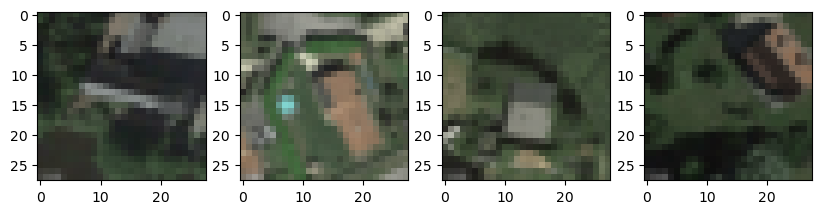

In [18]:
path_train = "C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test = "C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset = CustomImageDataset(path_train, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
]))
transformed_test_dataset = CustomImageDataset(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                              transform=transforms.Compose([
                                                  transforms.Resize(28),
                                                  transforms.ToTensor(),
                                              ]))


train_dataloader = DataLoader(
    transformed_train_dataset, batch_size=23045, shuffle=True)
test_dataloader = DataLoader(
    transformed_test_dataset, batch_size=5762, shuffle=True)

X_train, Y_train = next(iter(train_dataloader))
X_test, Y_test = next(iter(test_dataloader))

X_train_permute = X_train.permute(0, 2, 3, 1)
X_test_permute = X_test.permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, 4, figsize=(10, 10))

axs[0].imshow(X_train_permute[0].numpy())
axs[1].imshow(X_train_permute[1].numpy())
axs[2].imshow(X_train_permute[2].numpy())
axs[3].imshow(X_train_permute[3].numpy())


In [19]:
model_init = buildModel()

history = model_init.fit(x=X_train_permute.numpy(), y=Y_train.numpy(),
                         validation_data=(
                             X_test_permute.numpy(), Y_test.numpy()),
                         batch_size=32,
                         epochs=10)


Epoch 1/10
721/721 [==============================] - 10s 11ms/step - loss: 0.5219 - Accuracy: 0.7503 - recall_m: 0.7830 - precision_m: 0.7642 - f1_m: 0.7624 - f2_m: 0.7720 - val_loss: 0.4577 - val_Accuracy: 0.8138 - val_recall_m: 0.7594 - val_precision_m: 0.8705 - val_f1_m: 0.8066 - val_f2_m: 0.7767
Epoch 2/10
721/721 [==============================] - 8s 10ms/step - loss: 0.4535 - Accuracy: 0.8115 - recall_m: 0.8241 - precision_m: 0.8225 - f1_m: 0.8170 - f2_m: 0.8198 - val_loss: 0.4185 - val_Accuracy: 0.8306 - val_recall_m: 0.8700 - val_precision_m: 0.8178 - val_f1_m: 0.8396 - val_f2_m: 0.8566
Epoch 3/10
721/721 [==============================] - 7s 10ms/step - loss: 0.4257 - Accuracy: 0.8240 - recall_m: 0.8365 - precision_m: 0.8337 - f1_m: 0.8301 - f2_m: 0.8327 - val_loss: 0.3969 - val_Accuracy: 0.8438 - val_recall_m: 0.8503 - val_precision_m: 0.8507 - val_f1_m: 0.8469 - val_f2_m: 0.8481
Epoch 4/10
721/721 [==============================] - 7s 10ms/step - loss: 0.4106 - Accuracy: 0.

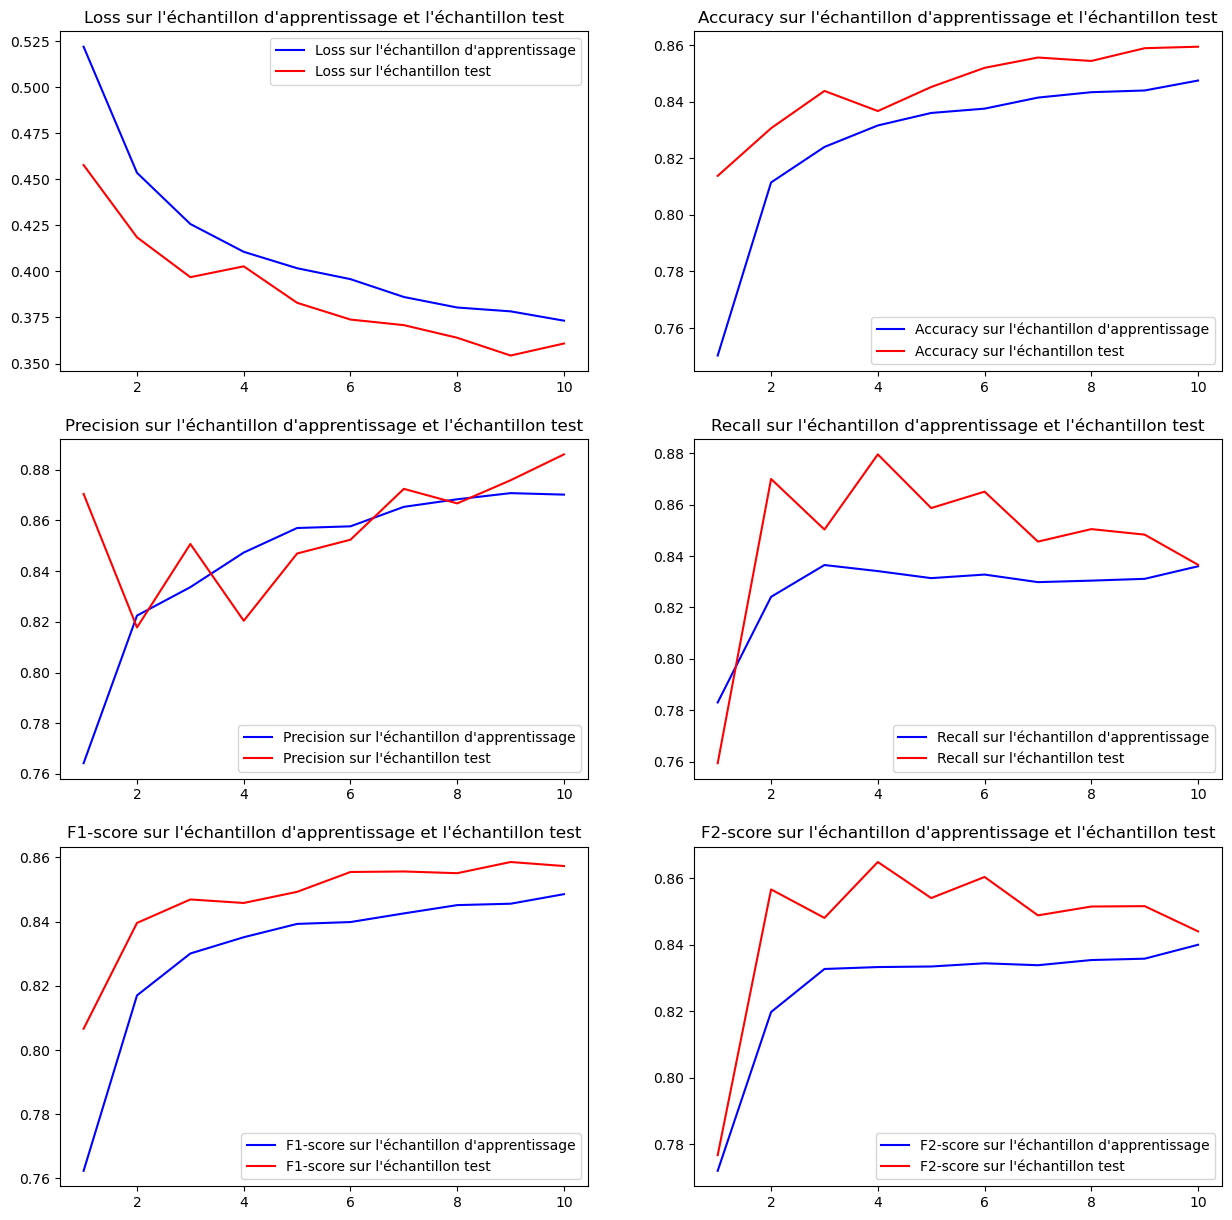

In [20]:
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']

accuracy = history.history['Accuracy']
val_accuracy = history.history['val_Accuracy']

precision = history.history['precision_m']
val_precision = history.history['val_precision_m']

f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']

f2 = history.history['f2_m']
val_f2 = history.history['val_f2_m']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(recall) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs, loss, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs, val_loss, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs, accuracy, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs, val_accuracy, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs, precision, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs, val_precision, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs, recall, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs, val_recall, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs, f1, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs, val_f1, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

axs[2, 1].plot(epochs, f2, 'b', label="F2-score sur l'échantillon d'apprentissage")
axs[2, 1].plot(epochs, val_f2, 'b', label="F2-score sur l'échantillon test", color="red")
axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 1].legend()




In [21]:
train_loss, train_accuracy, train_recall, train_precision, train_f1score, train_f2score = model_init.evaluate(
    X_train_permute.numpy(), Y_train.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(train_loss, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(train_accuracy, 3)))
print("Recall sur l'échantillon train: {}".format(round(train_recall, 3)))
print("Precision sur l'échantillon train: {}".format(round(train_precision, 3)))
print("F1-score sur l'échantillon train: {}".format(round(train_f1score, 3)))
print("F2-score sur l'échantillon train: {}".format(round(train_f2score, 3)))

loss, accuracy, recall, precision, f1score, f2score = model_init.evaluate(
    X_test_permute.numpy(), Y_test.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score, 3)))
print("F2-score sur l'échantillon test: {}".format(round(f2score, 3)))

prob_predict = model_init.predict(X_test_permute.numpy())
y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

unique, counts = np.unique(y_pred, return_counts=True)
res = dict(zip(unique, counts))
print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
print("Nombre d'images prédites sans panneau: {}".format(res[0]))

Loss sur l'échantillon train: 0.347
Accuracy sur l'échantillon train: 0.863
Recall sur l'échantillon train: 0.838
Precision sur l'échantillon train: 0.897
F1-score sur l'échantillon train: 0.863
F2-score sur l'échantillon train: 0.847
Loss sur l'échantillon test: 0.361
Accuracy sur l'échantillon test: 0.859
Recall sur l'échantillon test: 0.837
Precision sur l'échantillon test: 0.886
F1-score sur l'échantillon test: 0.857
F2-score sur l'échantillon test: 0.844
181/181 [==============================] - 1s 4ms/step
Nombre d'images prédites avec panneaux: 2939
Nombre d'images prédites sans panneau: 2823


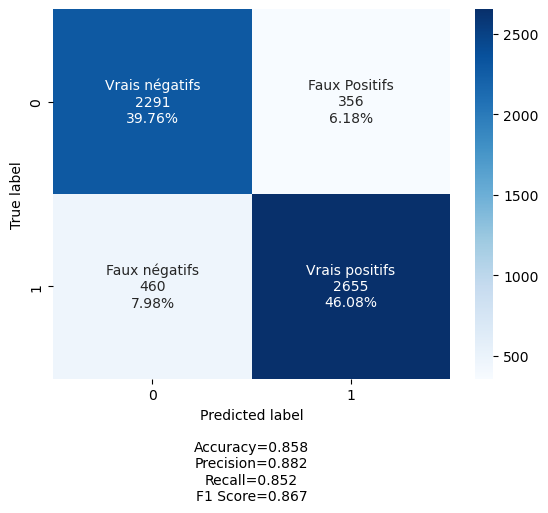

In [6]:
r = confusion_matrix(Y_test, y_pred)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      )


In [22]:
FPR, TPR, thresholds_keras = roc_curve(Y_test.numpy(), prob_predict)
AUC = auc(FPR, TPR)
print("AUC: {}".format(round(AUC, 2)))

AUC: 0.92


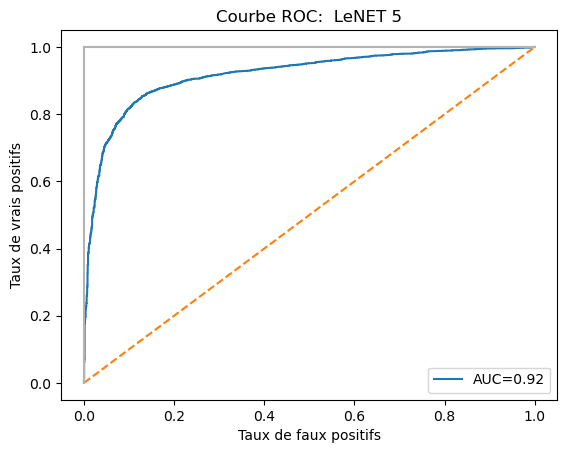

In [23]:
plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()


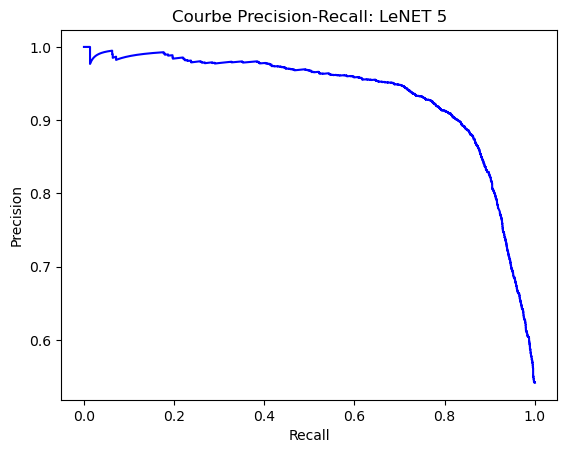

In [24]:
prec, rec, thresholds_keras = precision_recall_curve(Y_test.numpy(), prob_predict)

fig, ax = plt.subplots()
ax.plot(rec, prec, color='blue')

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET 5')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

## Ajout de data augmentations (Sans Crop)

Comme les images sont de dimension relativement faible, on ne met pas de crop. De plus, on évite le colorjitter pour ne pas "détruire les images". Enfin,  comme les panneaux sont orientés au nord, on ne met pas de rotations aléatoires. Enfin, on normalise les données d'apprentissage et de test.

In [37]:
transformed_train_dataset = CustomImageDataset(path_train, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),

]))

# On resize uniquement sur le test
transformed_test_dataset = CustomImageDataset(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                              transform=transforms.Compose([
                                                  transforms.Resize(28),
                                                  transforms.ToTensor(),
                                              ]))

train_dataloader = DataLoader(
    transformed_train_dataset, batch_size=23045, shuffle=True)
test_dataloader = DataLoader(
    transformed_test_dataset, batch_size=5762, shuffle=True)

mean_train, std_train = mean_std(train_dataloader)
print("Moyenne par channel: {}".format(mean_train.tolist()))
print("Ecart-type par channel: {}".format(std_train.tolist()))

mean_test, std_test = mean_std(test_dataloader)
print("Moyenne par channel: {}".format(mean_test.tolist()))
print("Ecart-type par channel: {}".format(std_test.tolist()))


normalized_train_dataset = CustomImageDataset(path_train, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ColorJitter(brightness=(0.5,1.5),contrast=0,saturation=0,hue=0),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train.tolist(),
                         std=std_train.tolist()),


]))


normalize_test_dataset = CustomImageDataset(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                                transforms.Resize(28),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=mean_test.tolist(),
                                                                     std=std_test.tolist()),
                                            ]))
train_dataloader_augmente = DataLoader(
    normalized_train_dataset, batch_size=23045, shuffle=True)
test_dataloader_augmente = DataLoader(
    normalize_test_dataset, batch_size=5762, shuffle=True)




Moyenne par channel: [0.3492555320262909, 0.3566363453865051, 0.3071678876876831]
Ecart-type par channel: [0.16620372235774994, 0.14752432703971863, 0.14564631879329681]
Moyenne par channel: [0.34999197721481323, 0.3576659858226776, 0.30810609459877014]
Ecart-type par channel: [0.16761955618858337, 0.14885342121124268, 0.1473139077425003]


## Apprentissage avec data augmentations

In [45]:
X_train_augmente, Y_train_augmente = next(iter(train_dataloader_augmente))
X_test_augmente, Y_test_augmente = next(iter(test_dataloader_augmente))

X_train_augmente_permute = X_train_augmente.permute(0, 2, 3, 1)
X_test_augmente_permute = X_test_augmente.permute(0, 2, 3, 1)

model_augmente = buildModel()

history_augmente = model_augmente.fit(x=X_train_augmente_permute.numpy(), y=Y_train_augmente.numpy(),
                                      validation_data=(
                                          X_test_augmente_permute.numpy(), Y_test_augmente.numpy()),
                                      batch_size=32,
                                      epochs=10)

Epoch 1/10
721/721 [==============================] - 6s 8ms/step - loss: 0.4902 - Accuracy: 0.7821 - recall_m: 0.8158 - precision_m: 0.7812 - f1_m: 0.7930 - f2_m: 0.8052 - val_loss: 0.4241 - val_Accuracy: 0.8200 - val_recall_m: 0.8870 - val_precision_m: 0.7952 - val_f1_m: 0.8339 - val_f2_m: 0.8635
Epoch 2/10
721/721 [==============================] - 6s 8ms/step - loss: 0.4285 - Accuracy: 0.8213 - recall_m: 0.8393 - precision_m: 0.8262 - f1_m: 0.8286 - f2_m: 0.8339 - val_loss: 0.3898 - val_Accuracy: 0.8450 - val_recall_m: 0.8636 - val_precision_m: 0.8447 - val_f1_m: 0.8495 - val_f2_m: 0.8567
Epoch 3/10
721/721 [==============================] - 6s 8ms/step - loss: 0.4029 - Accuracy: 0.8340 - recall_m: 0.8415 - precision_m: 0.8468 - f1_m: 0.8398 - f2_m: 0.8398 - val_loss: 0.3671 - val_Accuracy: 0.8542 - val_recall_m: 0.8659 - val_precision_m: 0.8558 - val_f1_m: 0.8571 - val_f2_m: 0.8614
Epoch 4/10
721/721 [==============================] - 6s 9ms/step - loss: 0.3889 - Accuracy: 0.8398 

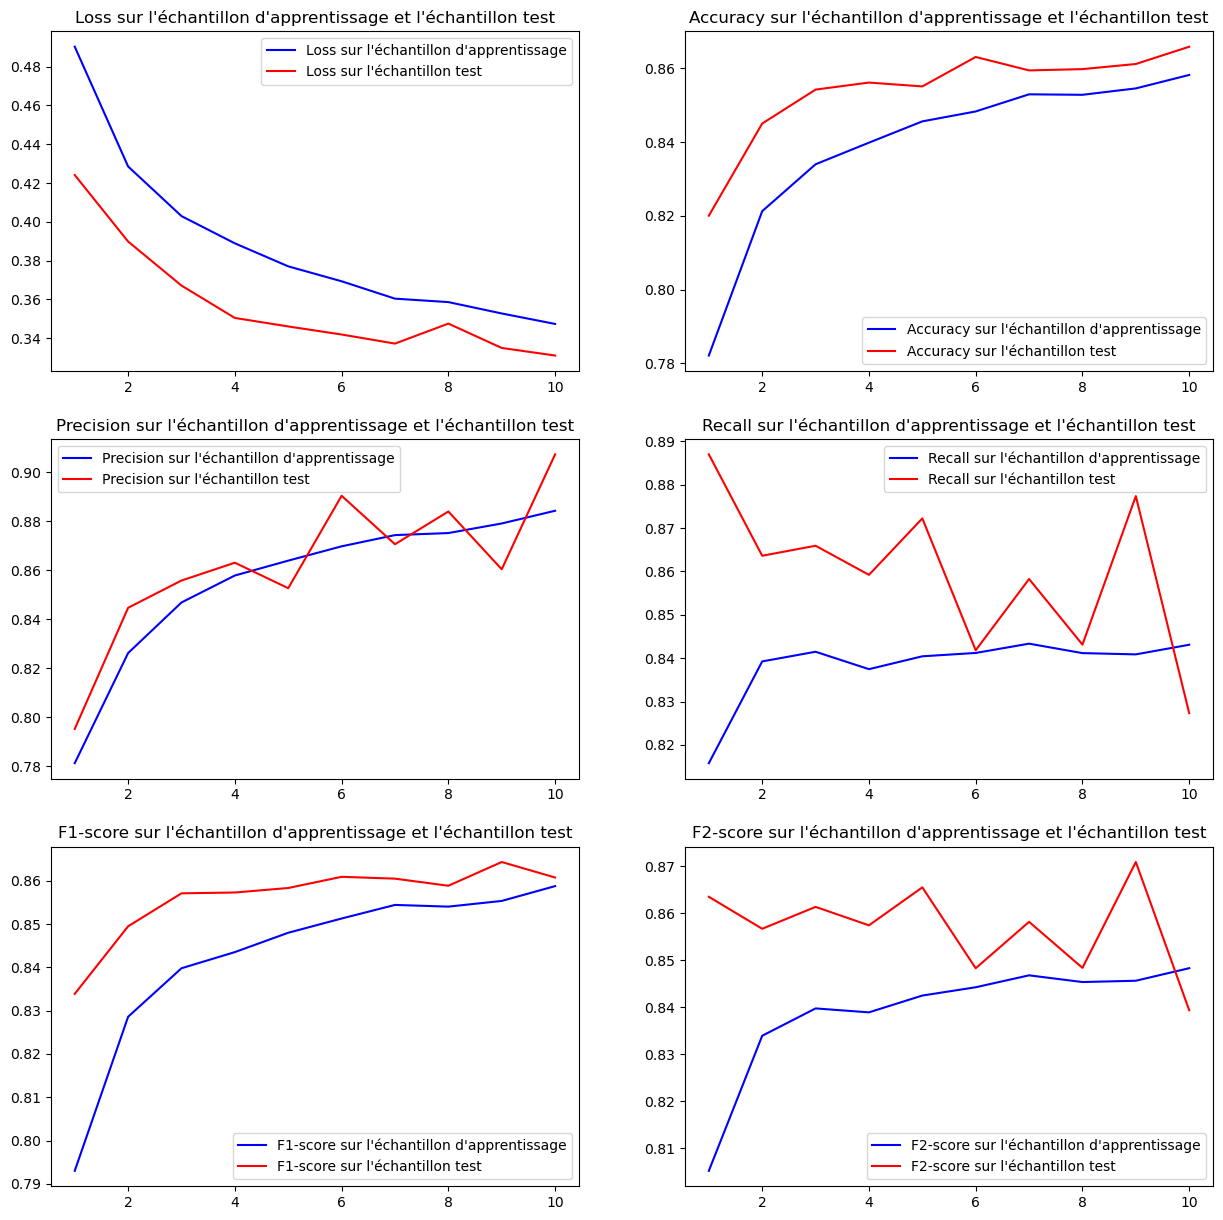

In [46]:
recall_augmente = history_augmente.history['recall_m']
val_recall_augmente = history_augmente.history['val_recall_m']

accuracy_augmente = history_augmente.history['Accuracy']
val_accuracy_augmente = history_augmente.history['val_Accuracy']

precision_augmente = history_augmente.history['precision_m']
val_precision_augmente = history_augmente.history['val_precision_m']

f1_augmente = history_augmente.history['f1_m']
val_f1_augmente = history_augmente.history['val_f1_m']

f2_augmente = history_augmente.history['f2_m']
val_f2_augmente = history_augmente.history['val_f2_m']

loss_augmente = history_augmente.history['loss']
val_loss_augmente = history_augmente.history['val_loss']

epochs_augmente = range(1, len(recall_augmente) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs_augmente, loss_augmente, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs_augmente, val_loss_augmente, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs_augmente, accuracy_augmente, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs_augmente, val_accuracy_augmente, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs_augmente, precision_augmente, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs_augmente, val_precision_augmente, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs_augmente, recall_augmente, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs_augmente, val_recall_augmente, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs_augmente, f1_augmente, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs_augmente, val_f1_augmente, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

axs[2, 1].plot(epochs_augmente, f2_augmente, 'b', label="F2-score sur l'échantillon d'apprentissage")
axs[2, 1].plot(epochs_augmente, val_f2_augmente, 'b', label="F2-score sur l'échantillon test", color="red")
axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 1].legend()




In [47]:
loss_augmente_train, accuracy_augmente_train, recall_augmente_train, precision_augmente_train, f1score_augmente_train, f2score_augmente_train = model_augmente.evaluate(
    X_train_augmente_permute.numpy(), Y_train_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(loss_augmente_train, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(accuracy_augmente_train, 3)))
print("Recall sur l'échantillon train: {}".format(round(recall_augmente_train, 3)))
print("Precision sur l'échantillon train: {}".format(round(precision_augmente_train, 3)))
print("F1-score sur l'échantillon train: {}".format(round(f1score_augmente_train, 3)))
print("F2-score sur l'échantillon train: {}".format(round(f2score_augmente_train, 3)))

loss_augmente, accuracy_augmente, recall_augmente, precision_augmente, f1score_augmente, f2score_augmente = model_augmente.evaluate(
    X_test_augmente_permute.numpy(), Y_test_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_augmente, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_augmente, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall_augmente, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision_augmente, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_augmente, 3)))
print("F2-score sur l'échantillon test: {}".format(round(f2score_augmente, 3)))

prob_predict_augmente = model_augmente.predict(X_test_augmente_permute.numpy())
y_pred_augmente = (np.squeeze(prob_predict_augmente) > 0.5).astype("int32")

unique_augmente, counts_augmente = np.unique(
    y_pred_augmente, return_counts=True)
res_augmente = dict(zip(unique_augmente, counts_augmente))
print("Nombre d'images prédites avec panneaux: {}".format(res_augmente[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_augmente[0]))



Loss sur l'échantillon train: 0.322
Accuracy sur l'échantillon train: 0.87
Recall sur l'échantillon train: 0.824
Precision sur l'échantillon train: 0.923
F1-score sur l'échantillon train: 0.867
F2-score sur l'échantillon train: 0.84
Loss sur l'échantillon test: 0.331
Accuracy sur l'échantillon test: 0.866
Recall sur l'échantillon test: 0.827
Precision sur l'échantillon test: 0.907
F1-score sur l'échantillon test: 0.861
F2-score sur l'échantillon test: 0.839
181/181 [==============================] - 0s 2ms/step
Nombre d'images prédites avec panneaux: 2832
Nombre d'images prédites sans panneau: 2930


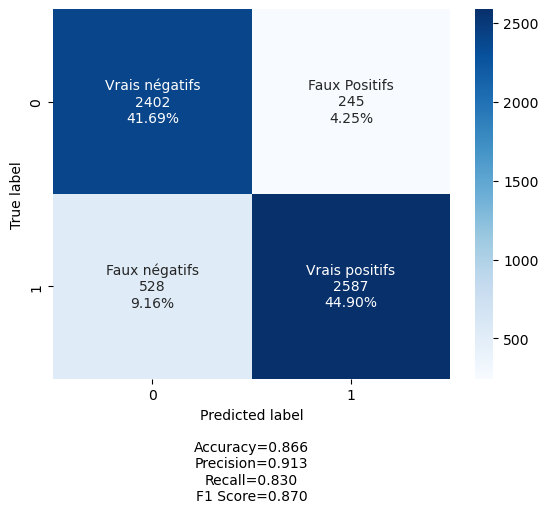

In [48]:
r = confusion_matrix(Y_test_augmente, y_pred_augmente)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      )


AUC: 0.93


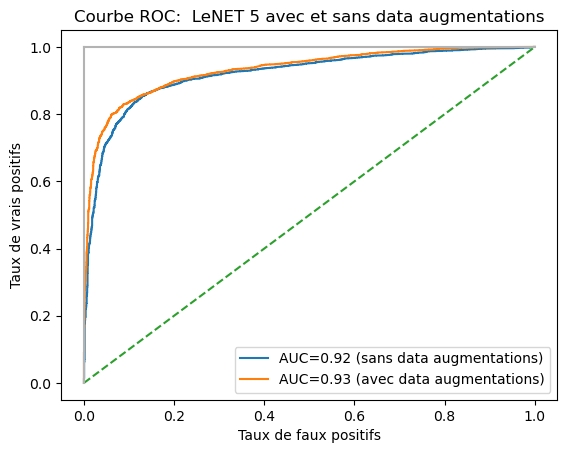

In [52]:
FPR_augmente, TPR_augmente, thresholds_keras_augmente = roc_curve(
    Y_test_augmente.numpy(), prob_predict_augmente)
AUC_augmente = auc(FPR_augmente, TPR_augmente)
print("AUC: {}".format(round(AUC_augmente, 2)))

plt.title('Courbe ROC:  LeNET 5 avec et sans data augmentations')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)) +
         " (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC=" +
         str(round(AUC_augmente, 2))+" (avec data augmentations)")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()


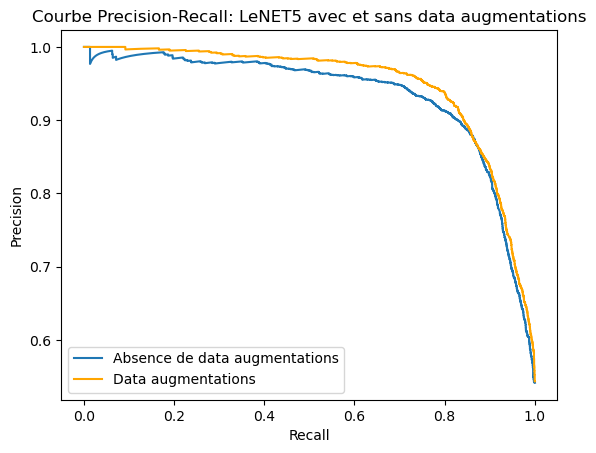

In [51]:
prec_augmente, rec_augmente, thresholds_keras = precision_recall_curve(Y_test_augmente.numpy(), prob_predict_augmente)

fig, ax = plt.subplots()
ax.plot(rec, prec, label="Absence de data augmentations")
ax.plot(rec_augmente, prec_augmente, color='orange', label="Data augmentations")

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET5 avec et sans data augmentations')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.legend(loc=0)
plt.show()

# Ajout de crop

In [74]:
crop_train_dataset = CustomImageDataset(path_train, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ColorJitter(brightness=(0.5,1.5),contrast=0,saturation=0,hue=0),
    transforms.RandomCrop(24), #On garde environ 75% de l'image
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train.tolist(),
                         std=std_train.tolist()),


]))


crop_test_dataset = CustomImageDataset(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                                transforms.Resize(28),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=mean_test.tolist(),
                                                                     std=std_test.tolist()),
                                            ]))
train_dataloader_crop = DataLoader(
    crop_train_dataset, batch_size=23045, shuffle=True)
test_dataloader_crop = DataLoader(
    crop_test_dataset, batch_size=5762, shuffle=True)

In [75]:
X_train_crop, Y_train_crop = next(iter(train_dataloader_crop))
X_test_crop, Y_test_crop = next(iter(test_dataloader_crop))

X_train_crop_permute = X_train_crop.permute(0, 2, 3, 1)
X_test_crop_permute = X_test_crop.permute(0, 2, 3, 1)

model_crop = buildModel()

history_crop= model_crop.fit(x=X_train_crop_permute.numpy(), y=Y_train_crop.numpy(),
                                      validation_data=(
                                          X_test_crop_permute.numpy(), Y_test_crop.numpy()),
                                      batch_size=32,
                                      epochs=10)

Epoch 1/10
721/721 [==============================] - 6s 8ms/step - loss: 0.5350 - Accuracy: 0.7440 - recall_m: 0.7860 - precision_m: 0.7467 - f1_m: 0.7599 - f2_m: 0.7738 - val_loss: 0.4414 - val_Accuracy: 0.8133 - val_recall_m: 0.8716 - val_precision_m: 0.7945 - val_f1_m: 0.8267 - val_f2_m: 0.8518
Epoch 2/10
721/721 [==============================] - 6s 8ms/step - loss: 0.4878 - Accuracy: 0.7782 - recall_m: 0.8060 - precision_m: 0.7833 - f1_m: 0.7888 - f2_m: 0.7976 - val_loss: 0.4282 - val_Accuracy: 0.8192 - val_recall_m: 0.8575 - val_precision_m: 0.8103 - val_f1_m: 0.8289 - val_f2_m: 0.8447
Epoch 3/10
721/721 [==============================] - 6s 8ms/step - loss: 0.4707 - Accuracy: 0.7887 - recall_m: 0.8088 - precision_m: 0.7961 - f1_m: 0.7973 - f2_m: 0.8029 - val_loss: 0.4129 - val_Accuracy: 0.8259 - val_recall_m: 0.8510 - val_precision_m: 0.8236 - val_f1_m: 0.8329 - val_f2_m: 0.8427
Epoch 4/10
721/721 [==============================] - 5s 7ms/step - loss: 0.4608 - Accuracy: 0.7956 

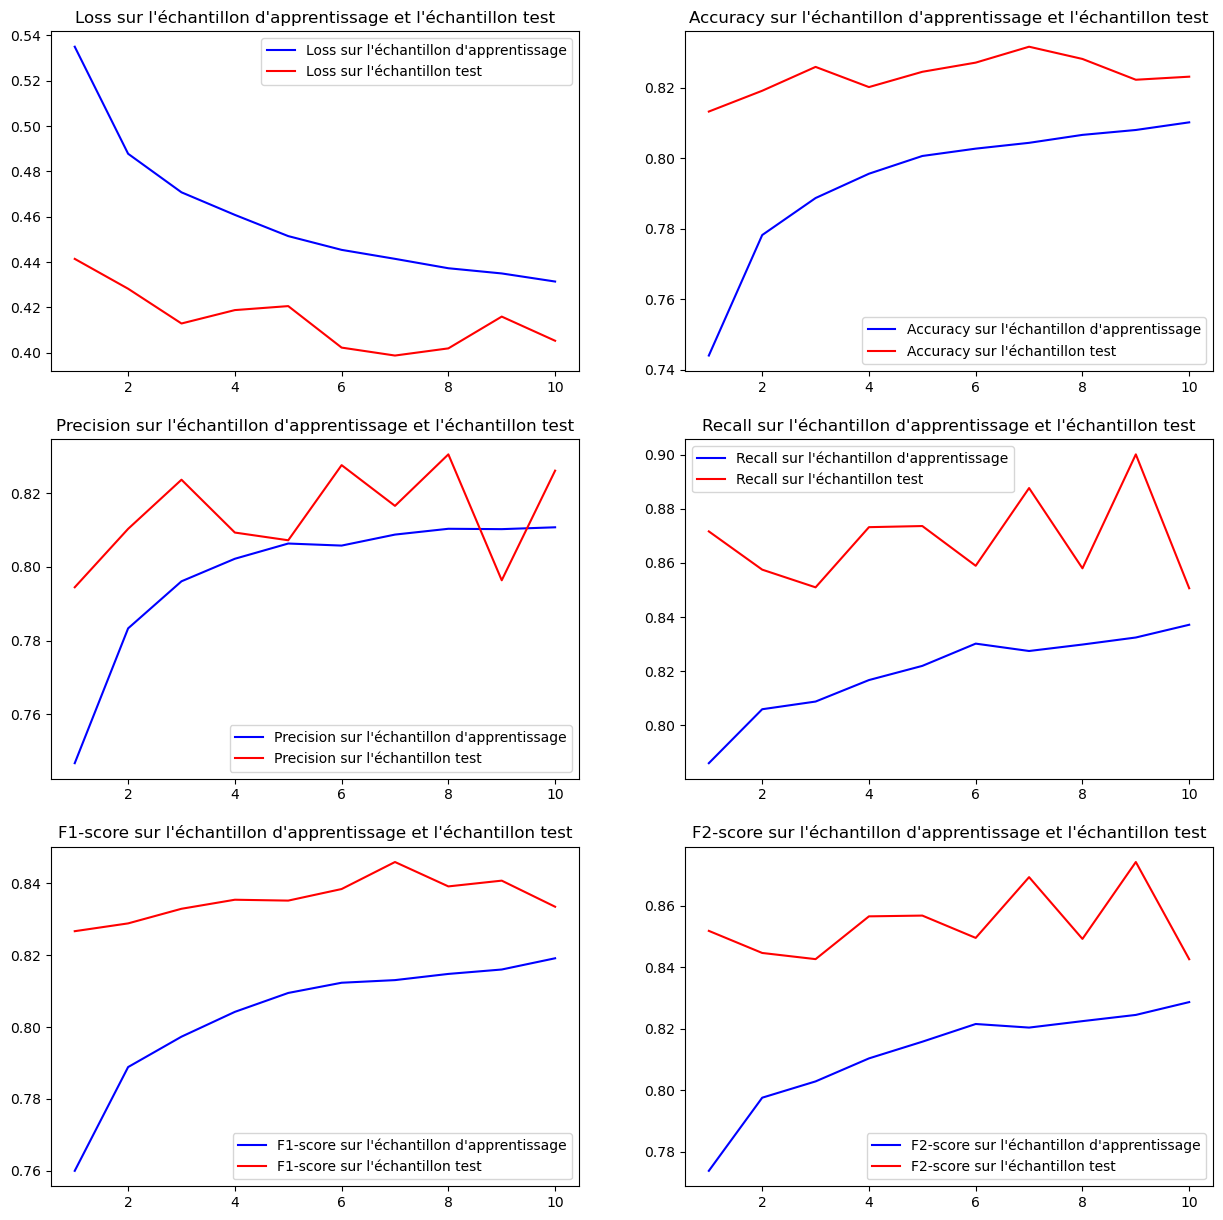

In [76]:
recall_crop = history_crop.history['recall_m']
val_recall_crop = history_crop.history['val_recall_m']

accuracy_crop = history_crop.history['Accuracy']
val_accuracy_crop = history_crop.history['val_Accuracy']

precision_crop = history_crop.history['precision_m']
val_precision_crop = history_crop.history['val_precision_m']

f1_crop = history_crop.history['f1_m']
val_f1_crop = history_crop.history['val_f1_m']

f2_crop = history_crop.history['f2_m']
val_f2_crop = history_crop.history['val_f2_m']

loss_crop = history_crop.history['loss']
val_loss_crop = history_crop.history['val_loss']

epochs_crop= range(1, len(recall_crop) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs_crop, loss_crop, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs_crop, val_loss_crop, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs_crop, accuracy_crop, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs_crop, val_accuracy_crop, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs_crop, precision_crop, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs_crop, val_precision_crop, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs_crop, recall_crop, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs_crop, val_recall_crop, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs_crop, f1_crop, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs_crop, val_f1_crop, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

axs[2, 1].plot(epochs_crop, f2_crop, 'b', label="F2-score sur l'échantillon d'apprentissage")
axs[2, 1].plot(epochs_crop, val_f2_crop, 'b', label="F2-score sur l'échantillon test", color="red")
axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 1].legend()

plt.show()

In [60]:
loss_crop_train, accuracy_crop_train, recall_crop_train, precision_crop_train, f1score_crop_train, f2score_crop_train = model_crop.evaluate(
    X_train_crop_permute.numpy(), Y_train_crop.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(loss_crop_train, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(accuracy_crop_train, 3)))
print("Recall sur l'échantillon train: {}".format(round(recall_crop_train, 3)))
print("Precision sur l'échantillon train: {}".format(round(precision_crop_train, 3)))
print("F1-score sur l'échantillon train: {}".format(round(f1score_crop_train, 3)))
print("F2-score sur l'échantillon train: {}".format(round(f2score_crop_train, 3)))

loss_crop, accuracy_crop, recall_crop, precision_crop, f1score_crop, f2score_crop = model_crop.evaluate(
    X_test_crop_permute.numpy(), Y_test_crop.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_crop, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_crop, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall_crop, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision_crop, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_crop, 3)))
print("F2-score sur l'échantillon test: {}".format(round(f2score_crop, 3)))

prob_predict_crop = model_crop.predict(X_test_crop_permute.numpy())
y_pred_crop= (np.squeeze(prob_predict_crop) > 0.5).astype("int32")

unique_crop, counts_crop = np.unique(
    y_pred_crop, return_counts=True)
res_crop= dict(zip(unique_crop, counts_crop))
print("Nombre d'images prédites avec panneaux: {}".format(res_crop[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_crop[0]))


Loss sur l'échantillon train: 0.452
Accuracy sur l'échantillon train: 0.793
Recall sur l'échantillon train: 0.86
Precision sur l'échantillon train: 0.774
F1-score sur l'échantillon train: 0.811
F2-score sur l'échantillon train: 0.838
Loss sur l'échantillon test: 0.478
Accuracy sur l'échantillon test: 0.772
Recall sur l'échantillon test: 0.869
Precision sur l'échantillon test: 0.746
F1-score sur l'échantillon test: 0.798
F2-score sur l'échantillon test: 0.838
181/181 [==============================] - 0s 2ms/step
Nombre d'images prédites avec panneaux: 3618
Nombre d'images prédites sans panneau: 2144


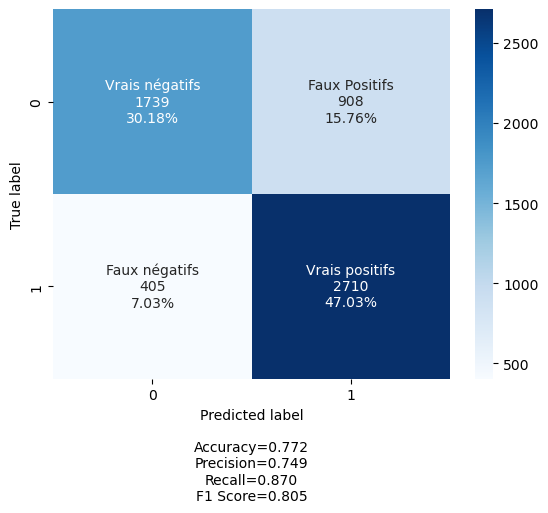

In [61]:
r = confusion_matrix(Y_test_crop, y_pred_crop)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      )


AUC: 0.85


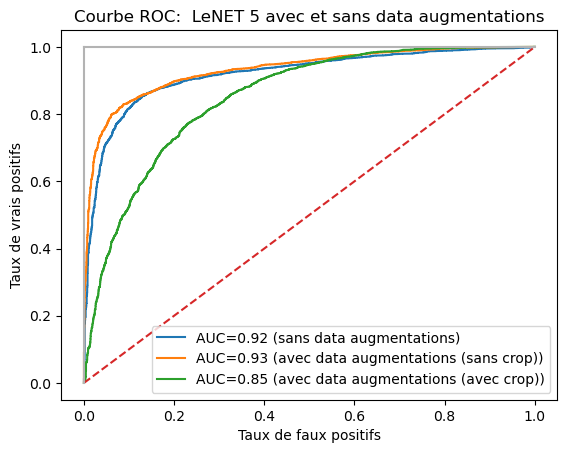

In [62]:
FPR_crop, TPR_crop, thresholds_keras_crop = roc_curve(
    Y_test_crop.numpy(), prob_predict_crop)
AUC_crop= auc(FPR_crop, TPR_crop)
print("AUC: {}".format(round(AUC_crop, 2)))

plt.title('Courbe ROC:  LeNET 5 avec et sans data augmentations')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)) +
         " (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC=" +
         str(round(AUC_augmente, 2))+" (avec data augmentations (sans crop))")
plt.plot(FPR_crop, TPR_crop, label="AUC=" +
         str(round(AUC_crop, 2))+" (avec data augmentations (avec crop))")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()

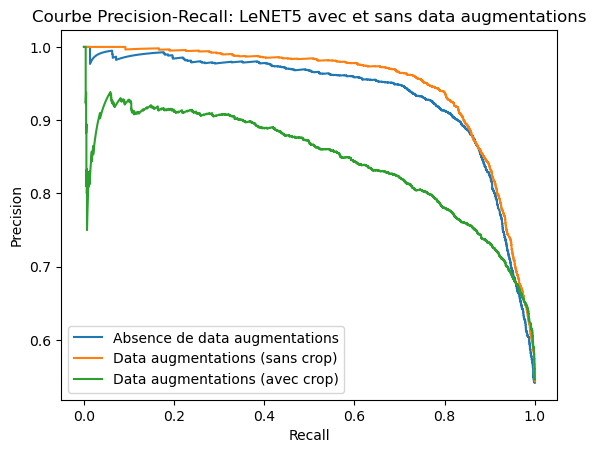

In [63]:
prec_crop, rec_crop, thresholds_keras = precision_recall_curve(Y_test_crop.numpy(), prob_predict_crop)

fig, ax = plt.subplots()
ax.plot(rec, prec, label="Absence de data augmentations")
ax.plot(rec_augmente, prec_augmente, label="Data augmentations (sans crop)")
ax.plot(rec_crop, prec_crop, label="Data augmentations (avec crop)")

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET5 avec et sans data augmentations')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.legend(loc=0)
plt.show()

Même si l'AUC est moins bon, on retient plutôt le modèle avec des crops pour limiter l'over-fitting.

# Hyperparamétrisation du modèle: random search

* n_iter: nombre de combinaisons d'hyperparamètres testées
* cv*n_iter = nombre d'itérations total

https://pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/

https://towardsdatascience.com/hyper-parameter-tuning-with-randomised-grid-search-54f865d27926

## Optimisation par rapport au f2-score

On cherche à tomber sur une proportion de 10% des meilleurs paramètres avec une confiance de 95%.

In [77]:
learnRate = [1e-2, 1e-3, 1e-4]
momentum = [0.9, 0.99]
dropout1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dropout2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dropout3 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dropout4 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
batchSize = [4, 8, 16, 32, 64, 128, 256]
epochs = [10, 20, 30, 40, 50]

grid = dict(
    learnRate=learnRate,
    momentum=momentum,
    dropout1=dropout1,
    dropout2=dropout2,
    dropout3=dropout3,
    dropout4=dropout4,
    batch_size=batchSize,
    epochs=epochs
)

model = KerasClassifier(build_fn=buildModel, verbose=1)
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# n_iter: nombre de modèles entrainés
searcher = RandomizedSearchCV(
    estimator=model, cv=5, n_iter=30, param_distributions=grid, scoring=ftwo_scorer)
searchResults = searcher.fit(
    X_train_crop_permute.numpy(), Y_train_crop.numpy())


Epoch 1/40
174/577 [========>.....................] - ETA: 3s - loss: 0.8861 - Accuracy: 0.5180 - recall_m: 0.5653 - precision_m: 0.5454 - f1_m: 0.5480 - f2_m: 0.5564

In [ ]:
# summarize grid search information
bestScore_recall = searchResults.best_score_
bestParams_recall = searchResults.best_params_
print("[INFO] best score is {} using {}".format(round(bestScore_recall, 3),
                                                bestParams_recall))

print(searchResults.cv_results_["mean_test_score"])

[INFO] best score is 0.896 using {'momentum': 0.99, 'learnRate': 0.001, 'epochs': 20, 'dropout4': 0.1, 'dropout3': 0.7, 'dropout2': 0.7, 'dropout1': 0.6, 'batch_size': 32}


## Résultats sur le modèle optimisé (recall)

In [ ]:
best_model_recall = buildModel(learnRate=0.001, dropout1=0.6, dropout2=0.7,
                        dropout3=0.7, dropout4=0.4, momentum=0.99)

history_best_recall = best_model_recall.fit(x=X_train_augmente_permute.numpy(), y=Y_train_augmente.numpy(),
                              validation_data=(
                                  X_test_augmente_permute.numpy(), Y_test_augmente.numpy()),
                              batch_size=32,
                              epochs=20)


Epoch 1/20
721/721 [==============================] - 7s 9ms/step - loss: 0.6539 - Accuracy: 0.6296 - recall_m: 0.7121 - precision_m: 0.6345 - f1_m: 0.6648 - val_loss: 0.6188 - val_Accuracy: 0.7393 - val_recall_m: 0.8959 - val_precision_m: 0.7054 - val_f1_m: 0.7840
Epoch 2/20
721/721 [==============================] - 6s 9ms/step - loss: 0.5557 - Accuracy: 0.7317 - recall_m: 0.7977 - precision_m: 0.7246 - f1_m: 0.7539 - val_loss: 0.5278 - val_Accuracy: 0.7824 - val_recall_m: 0.9081 - val_precision_m: 0.7456 - val_f1_m: 0.8142
Epoch 3/20
721/721 [==============================] - 6s 9ms/step - loss: 0.5323 - Accuracy: 0.7537 - recall_m: 0.8073 - precision_m: 0.7484 - f1_m: 0.7708 - val_loss: 0.4772 - val_Accuracy: 0.7985 - val_recall_m: 0.8812 - val_precision_m: 0.7772 - val_f1_m: 0.8211
Epoch 4/20
721/721 [==============================] - 6s 8ms/step - loss: 0.5119 - Accuracy: 0.7687 - recall_m: 0.8148 - precision_m: 0.7653 - f1_m: 0.7841 - val_loss: 0.4460 - val_Accuracy: 0.8146 - va

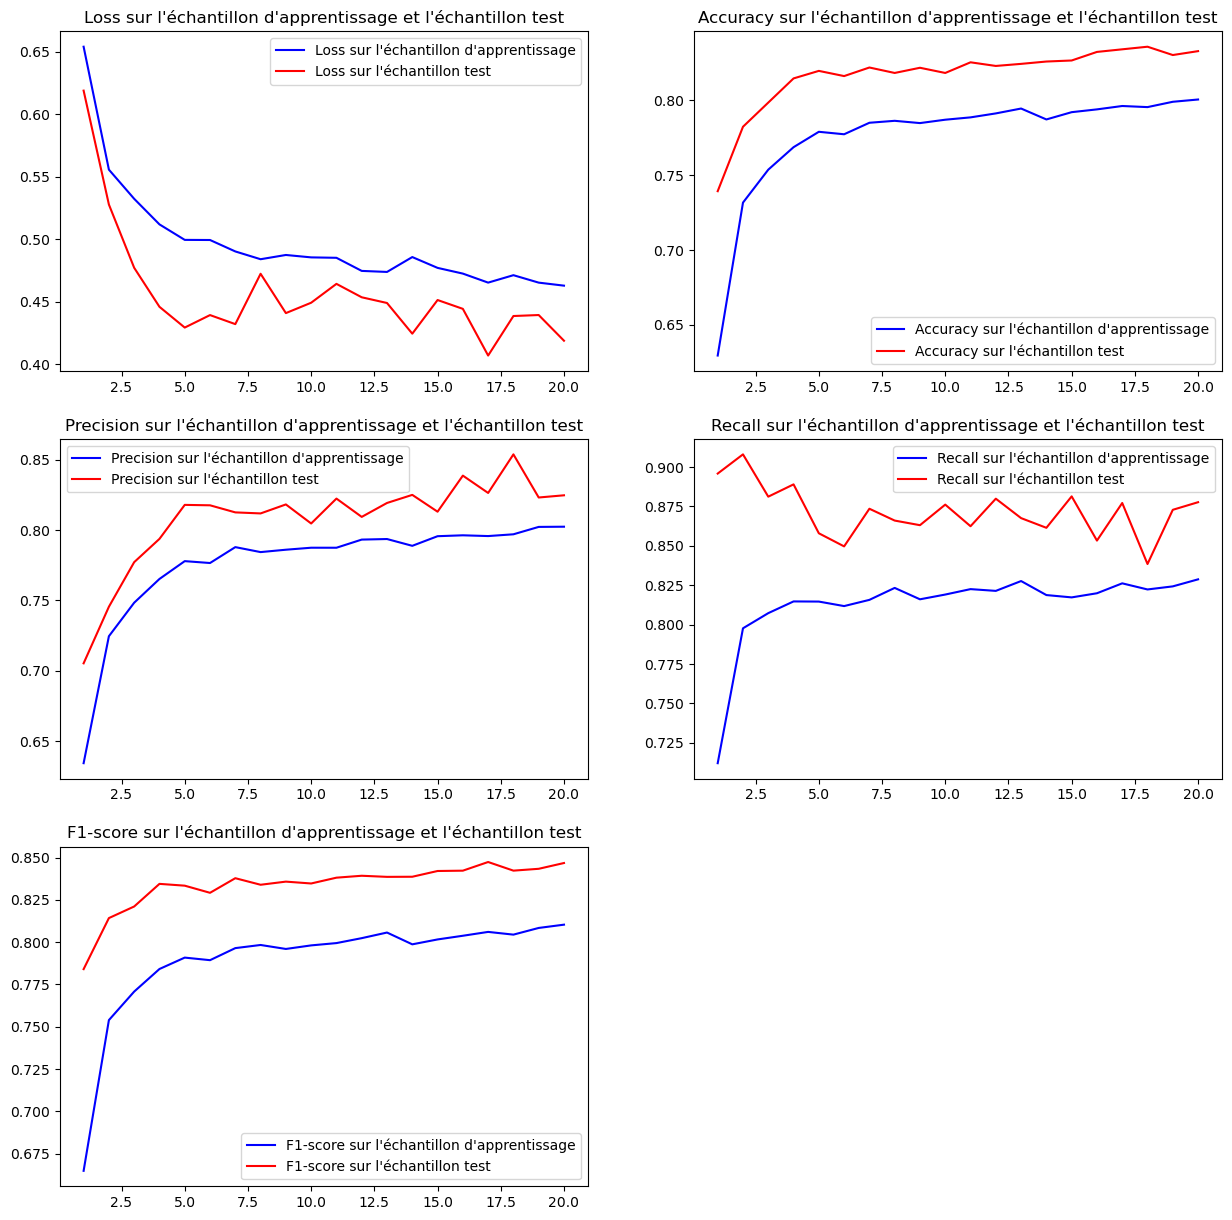

In [ ]:
recall_best_recall = history_best_recall.history['recall_m']
val_recall_best_recall = history_best_recall.history['val_recall_m']

accuracy_best_recall = history_best_recall.history['Accuracy']
val_accuracy_best_recall = history_best_recall.history['val_Accuracy']

precision_best_recall = history_best_recall.history['precision_m']
val_precision_best_recall = history_best_recall.history['val_precision_m']

f1_best_recall = history_best_recall.history['f1_m']
val_f1_best_recall = history_best_recall.history['val_f1_m']

f2_best_recall = history_best_recall.history['f2_m']
val_f2_best_recall = history_best_recall.history['val_f2_m']

loss_best_recall = history_best_recall.history['loss']
val_loss_best_recall = history_best_recall.history['val_loss']

epochs_best_recall = range(1, len(recall_best_recall) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs_best_recall, loss_best_recall, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs_best_recall, val_loss_best_recall, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs_best_recall, accuracy_best_recall, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs_best_recall, val_accuracy_best_recall, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs_best_recall, precision_best_recall, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs_best_recall, val_precision_best_recall, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs_best_recall, recall_best_recall, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs_best_recall, val_recall_best_recall, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs_best_recall, f1_best_recall, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs_best_recall, val_f1_best_recall, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

axs[2, 1].plot(epochs_best_recall, f2_best_recall, 'b', label="F2-score sur l'échantillon d'apprentissage")
axs[2, 1].plot(epochs_best_recall, val_f2_best_recall, 'b', label="F2-score sur l'échantillon test", color="red")
axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 1].legend()




In [ ]:
loss_best_train_recall, accuracy_best_train_recall, recall_best_train_recall, precision_best_train_recall, f1score_best_train_recall, f2score_best_train_recall = best_model_recall.evaluate(
    X_train_augmente_permute.numpy(), Y_train_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(loss_best_train_recall, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(accuracy_best_train_recall, 3)))
print("Recall sur l'échantillon train: {}".format(round(recall_best_train_recall, 3)))
print("Precision sur l'échantillon train: {}".format(round(precision_best_train_recall, 3)))
print("F1-score sur l'échantillon train: {}".format(round(f1score_best_train_recall, 3)))
print("F2-score sur l'échantillon train: {}".format(round(f2score_best_train_recall, 3)))

loss_best_recall, accuracy_best_recall, recall_best_recall, precision_best_recall, f1score_best_recall, f2score_best_recall = best_model_recall.evaluate(
    X_test_augmente_permute.numpy(), Y_test_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_best_recall, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_best_recall, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall_best_recall, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision_best_recall, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_best_recall, 3)))
print("F2-score sur l'échantillon test: {}".format(round(f2score_best_recall, 3)))

best_predict_recall = best_model_recall.predict(X_test_augmente_permute.numpy())
best_y_pred_recall = (np.squeeze(best_predict_recall) > 0.5).astype("int32")

uni_best, compteur_best = np.unique(best_y_pred_recall, return_counts=True)
res_best_recall = dict(zip(uni_best, compteur_best))
print("Nombre d'images prédites avec panneaux: {}".format(res_best_recall[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_best_recall[0]))

Loss sur l'échantillon train: 0.425
Accuracy sur l'échantillon train: 0.831
Recall sur l'échantillon train: 0.872
Precision sur l'échantillon train: 0.82
F1-score sur l'échantillon train: 0.841
Loss sur l'échantillon test: 0.419
Accuracy sur l'échantillon test: 0.833
Recall sur l'échantillon test: 0.878
Precision sur l'échantillon test: 0.825
F1-score sur l'échantillon test: 0.847
181/181 [==============================] - 0s 2ms/step
Nombre d'images prédites avec panneaux: 3310
Nombre d'images prédites sans panneau: 2452


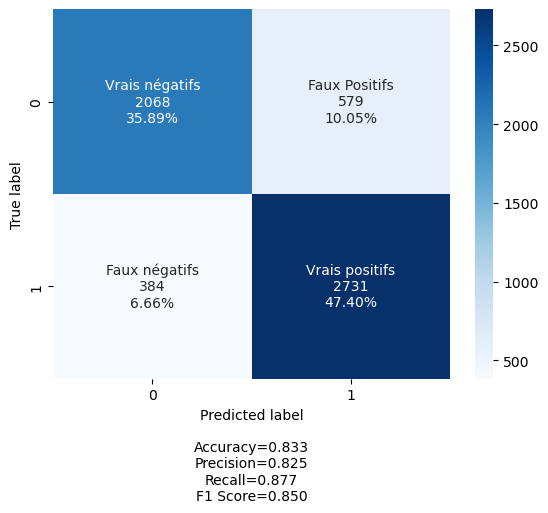

In [ ]:
r = confusion_matrix(Y_test_augmente, best_y_pred_recall)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      )


In [ ]:
FPR_best_recall, TPR_best_recall, thresholds_keras_best_recall = roc_curve(
    Y_test_augmente.numpy(), best_predict_recall)
AUC_best_recall = auc(FPR_best_recall, TPR_best_recall)
print("AUC: {}".format(round(AUC_best_recall, 2)))


AUC: 0.9


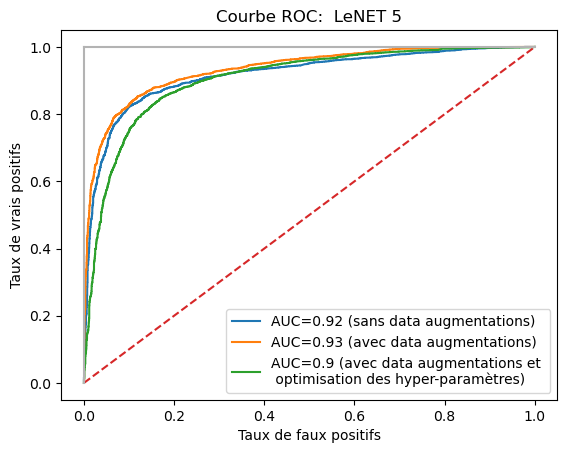

In [ ]:
plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)) +
         " (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC=" +
         str(round(AUC_augmente, 2))+" (avec data augmentations)")
plt.plot(FPR_best_recall, TPR_best_recall, label="AUC="+str(round(AUC_best_recall, 2)) +
         " (avec data augmentations et \n optimisation des hyper-paramètres)")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()


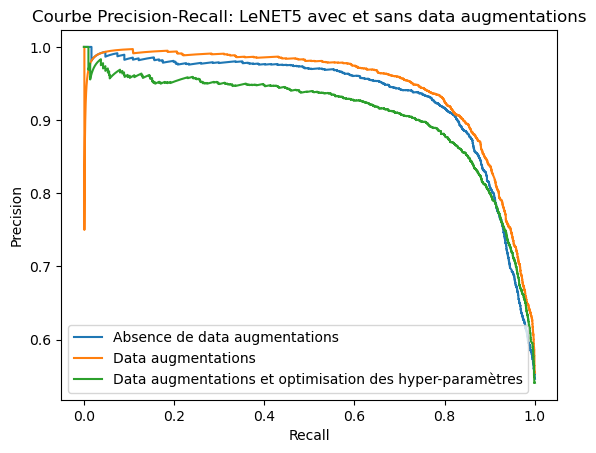

In [ ]:
prec_best_recall, rec_best_recall, thresholds_keras_best_recall = precision_recall_curve(Y_test_augmente.numpy(), best_predict_recall)

fig, ax = plt.subplots()
ax.plot(rec, prec, label="Absence de data augmentations")
ax.plot(rec_augmente, prec_augmente, label="Data augmentations")
ax.plot(rec_best_recall, prec_best_recall, label="Data augmentations et optimisation des hyper-paramètres")

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET5 avec et sans data augmentations')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.legend(loc=0)
plt.show()